## Fake news classification (kaggle)

#### Source: https://www.kaggle.com/c/fake-news
The Project is designed to analyze and classify news sources
for authenticity and accuracy

##### Steps involved in deep learning RNN analysis

- Read the text and classification label
- Tokenize the text and clean
- Perform word embedding
- Train RNN/LSTM model



###### References:

###### - https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b
- https://github.com/msahamed/yelp_comments_classification_nlp
###### - https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47
- https://github.com/nsinha280/lstm-on-Yelp-review-data/blob/master/lstm-final.ipynb

In [1]:
#!python -m ipykernel list
!pip install langdetect

    100% |████████████████████████████████| 1.0MB 641kB/s ta 0:00:01
  Running setup.py bdist_wheel for langdetect ... done
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
## Input libraries

## system libraries

import os
import sys
import glob
import re

## analysis libraries

import pandas as pd
import numpy as np


## text and language processing
from langdetect import detect
import string
#from string import punctuation
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
#nltk.download('stopwords')
#nltk.download('punkt')

import pydot

from nltk.corpus import stopwords

from sklearn.manifold import TSNE
## Keras
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Bidirectional
from keras.layers.embeddings import Embedding
from keras.utils.vis_utils import plot_model




## plotting
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
%matplotlib inline

!python --version

Using TensorFlow backend.


Python 3.6.3


In [3]:
## Data source and files

dir_data = r'data'

file_train = r'data/train.csv'
file_train_clean = r'train_clean.tsv'
file_test = r'data/test.csv'

In [4]:
#### Train Data summary

train_all_df = pd.read_csv(file_train)

print(train_all_df.shape)
train_all_df.head()

(20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


#### Remove empty articles

In [5]:
## remove empty cells
train_all_df = train_all_df[train_all_df.text.apply(lambda x: x !="")]

print(train_all_df.shape)

(20800, 5)


In [6]:
## replace empty cells with NAN and remove rows with NA
train_all_df['text'].replace('', np.nan, inplace=True)

train_all_df.dropna(inplace=True,subset=['text','label'])

train_all_df['text'].isnull().sum()

print(train_all_df.shape)

(20761, 5)


In [7]:
## summary of article labels by author and text
#article_type_count = train_all_df[['author','label','text']].groupby(['label']).count().plot.bar(fontsize=20,figsize=(18, 9))

article_type_count = train_all_df[['author','label','text']].groupby(['label']).count()
article_type_count.reset_index(level=0, inplace=True)

## melt dataframe
melted = pd.melt(article_type_count,id_vars='label')

melted

,label,variable,value
0,0,author,10361
1,1,author,8482
2,0,text,10387
3,1,text,10374


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


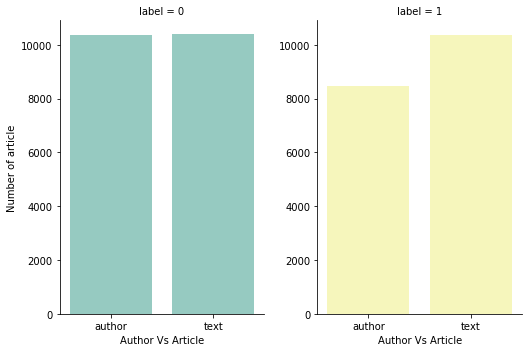

In [8]:
## plot barplot with seaborn


g = sns.FacetGrid(melted, col="label",hue="label",palette="Set3",size=5, aspect=0.75)
g.map(sns.barplot,'variable','value')\
.set_axis_labels("Author Vs Article", "Number of article")

In [9]:
train_all_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
### Detect the language of the text article in a list

def lang_detect_list(list_docs):
    """
    Check if txt exit, Check lang
    else, print n lang
    """
    lang = []
    for obj in list_docs:
        obj = obj[:100]
        if re.search('\w',obj):
        #if isinstance(obj, str) and obj is not None:
            #print('obj is a string!')
            #print(detect(obj)) # for x in train_all_df['text'][:10]]
            try:
                lang_str = detect(obj)
            except:
                lang_str = 'exception'
            
            lang.append(lang_str)

        else:
            lang.append('NoString')
            
    return(lang)

In [11]:
#train_all_df.
#lang_detect_list(train_all_df['text'][:200])

lang_list = lang_detect_list(train_all_df['text'])

In [12]:
## add the language as a column 
train_all_df['lang'] = lang_detect_list(train_all_df['text'])

In [13]:
train_all_df.head()

,id,title,author,text,label,lang
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,en
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,en
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,en
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,en
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,en


In [14]:
## write the modified data as a file
out_file = dir_data + '/' + file_train_clean
train_all_df.to_csv(out_file,sep='\t')


In [15]:
## Languages for articles

lang_label_summary = train_all_df[['lang','label','author']].groupby(['lang','label']).agg('count').reset_index()

lang_label_summary.head()

,lang,label,author
0,NoString,1,75
1,af,0,1
2,af,1,2
3,ar,1,4
4,ca,1,5


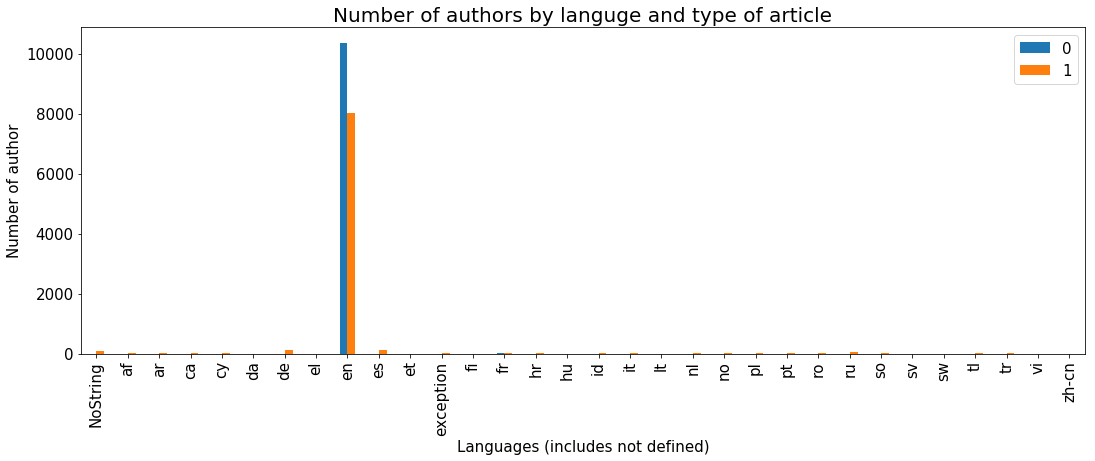

In [16]:
## plot the number of articles by language and article type

ax = lang_label_summary.pivot(index='lang',columns='label',values='author').plot.bar(fontsize=15,figsize=(18, 6))

ax.set_xlabel("Languages (includes not defined)",fontsize=15)
ax.set_ylabel("Number of author",fontsize=15)
ax.set_title('Number of authors by languge and type of article',fontsize= 20) 
ax.legend(fontsize=15)

#### Non english articles 

In [17]:
train_all_df[train_all_df['lang'] == 'en'].shape

(20098, 6)

In [18]:
train_all_df = train_all_df[train_all_df['lang'] == 'en']

#### Tokenize the text and clean

In [19]:

df_all = train_all_df[['text','label']]

### select rows
#df = df_all.iloc[0:500]
#labels =
df = df_all

### Create sequence
vocabulary_size = 20000

tokenizer = Tokenizer(num_words= vocabulary_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,split=' ')
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
data_all = pad_sequences(sequences, maxlen=50)

In [20]:
data = data_all[:15000]
label = df.iloc[:15000,1]
len(data)
#print(data[:10])

15000

#### Build the word embedding LSTM model 1

In [21]:
## Network architecture
embeding_size = 128

model1 = Sequential()
model1.add(Embedding(20000, embeding_size, input_length=50))
model1.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Show the model
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               167400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 2,727,551
Trainable params: 2,727,551
Non-trainable params: 0
_________________________________________________________________


In [22]:
#plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Run the model

In [23]:
## Fit the model
model1.fit(data, np.array(label), validation_split=0.2, epochs=25)

Train on 12000 samples, validate on 3000 samples
Epoch 1/25
12000/12000 [==============================] - 40s 3ms/step - loss: 0.3247 - acc: 0.8540 - val_loss: 0.2649 - val_acc: 0.8917
Epoch 2/25
12000/12000 [==============================] - 37s 3ms/step - loss: 0.1492 - acc: 0.9469 - val_loss: 0.2612 - val_acc: 0.9030
Epoch 3/25
12000/12000 [==============================] - 37s 3ms/step - loss: 0.0733 - acc: 0.9748 - val_loss: 0.3542 - val_acc: 0.8877
Epoch 4/25
12000/12000 [==============================] - 37s 3ms/step - loss: 0.0423 - acc: 0.9854 - val_loss: 0.3886 - val_acc: 0.8927
Epoch 5/25
12000/12000 [==============================] - 37s 3ms/step - loss: 0.0194 - acc: 0.9932 - val_loss: 0.5063 - val_acc: 0.8830
Epoch 6/25
12000/12000 [==============================] - 38s 3ms/step - loss: 0.0181 - acc: 0.9943 - val_loss: 0.4744 - val_acc: 0.8770
Epoch 7/25
12000/12000 [==============================] - 38s 3ms/step - loss: 0.0167 - acc: 0.9948 - val_loss: 0.4914 - val_acc:

#### Evaluate the model

In [24]:
## Evaluate the model
X_test = data_all[15000:]
Y_test =  df.iloc[15000:,1]

In [25]:

score,acc  =  model1.evaluate(X_test, Y_test, verbose = 2)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 0.78
Validation Accuracy: 0.89


prediction_sigmoid 

In [26]:
## Prediction of the labels

prediction_sigmoid = model1.predict(X_test, verbose = 2)

In [27]:
## Convert prediction (floats) to integer and compile predictions

print(prediction_sigmoid.shape)

predict_sigmoid_round = prediction_sigmoid.round()

#print(predict_sigmoid_round)

print(np.reshape(predict_sigmoid_round,len(predict_sigmoid_round)).shape)

predicted_label = list(np.reshape(predict_sigmoid_round,len(predict_sigmoid_round)))

(5098, 1)
(5098,)


In [28]:
## Compute the TP, TN, FP, FN values

def get_matrics_binary(Y_original,Y_prediction):
    """
    Input list of original and preidcted labels 
    for binary classifiers (0,1)
    """
    Y_original = np.asarray(Y_original)
    Y_prediction = np.asarray(Y_prediction)
    
    if len(Y_original) == len(Y_prediction):
        ## TP
        TP = np.sum(np.logical_and(Y_original == 1, Y_prediction == 1)) 
        
        ## FP
        TN = np.sum(np.logical_and(Y_original == 0, Y_prediction == 0))
        
        ## 
        FP = np.sum(np.logical_and(Y_original == 0, Y_prediction == 1)) 
        
        ## FP
        FN = np.sum(np.logical_and(Y_original == 1, Y_prediction == 0))
        
    return(TP,TN,FP,FN)




#### Evaluation matrices

- Precision 
- Recall
- F beta-score


In [29]:
TP,TN,FP,FN = get_matrics_binary(Y_test,predicted_label)

In [30]:
## Calculate TP, TN, FP, FN, Precision, Recall and F1 score
def get_prec_recall_f1(TP,TN,FP,FN):
    """
    Input provide the values for TP,TN,FP,FN
    Output: get the precision, recall and the F1 score
    """
    ## Calculate precision and recall
    recall = float(TP)/(TP + FN)
    precision = float(TP)/(TP + FP)

    print("Recall: {}, Precision: {}".format(recall, precision))
    
    ## Calculate F-score using the formula with beta = 0.5
    beta = 0.5
    fscore = (1 + beta**2) * (precision * recall)/((beta**2)*precision + recall)
    # Print the results 
    print("F beta-score: {}".format(fscore))

In [31]:
get_prec_recall_f1(TP,TN,FP,FN)

Recall: 0.8942268873637464, Precision: 0.8754940711462451
F beta-score: 0.8791775819639597


#### Build the word embedding bidirectional LSTM model 2

In [39]:
## Network architecture
embeding_size = 128

model2 = Sequential()
model2.add(Embedding(20000, embeding_size, input_length=50))
model2.add(Bidirectional(LSTM(150, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Show the model
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 128)           2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300)               334800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 2,895,101
Trainable params: 2,895,101
Non-trainable params: 0
_________________________________________________________________


In [40]:
## Fit the model
model2.fit(data, np.array(label), validation_split=0.2, epochs=25)

Train on 12000 samples, validate on 3000 samples
Epoch 1/25
12000/12000 [==============================] - 81s 7ms/step - loss: 0.3284 - acc: 0.8562 - val_loss: 0.2664 - val_acc: 0.8903
Epoch 2/25
12000/12000 [==============================] - 79s 7ms/step - loss: 0.1312 - acc: 0.9522 - val_loss: 0.2538 - val_acc: 0.8973
Epoch 3/25
12000/12000 [==============================] - 78s 7ms/step - loss: 0.0719 - acc: 0.9747 - val_loss: 0.3372 - val_acc: 0.8887
Epoch 4/25
12000/12000 [==============================] - 79s 7ms/step - loss: 0.0404 - acc: 0.9880 - val_loss: 0.3836 - val_acc: 0.8903
Epoch 5/25
12000/12000 [==============================] - 79s 7ms/step - loss: 0.0153 - acc: 0.9952 - val_loss: 0.5196 - val_acc: 0.8780
Epoch 6/25
12000/12000 [==============================] - 79s 7ms/step - loss: 0.0108 - acc: 0.9969 - val_loss: 0.4743 - val_acc: 0.8903
Epoch 7/25
12000/12000 [==============================] - 79s 7ms/step - loss: 0.0074 - acc: 0.9977 - val_loss: 0.5515 - val_acc:

In [41]:
## Evaluation of model 2


score,acc  =  model2.evaluate(X_test, Y_test, verbose = 2)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 0.81
Validation Accuracy: 0.89


In [42]:
## Prediction of the labels

prediction_sigmoid = model2.predict(X_test, verbose = 2)

## Convert prediction (floats) to integer and compile predictions

print(prediction_sigmoid.shape)

predict_sigmoid_round = prediction_sigmoid.round()

#print(predict_sigmoid_round)

print(np.reshape(predict_sigmoid_round,len(predict_sigmoid_round)).shape)

predicted_label = list(np.reshape(predict_sigmoid_round,len(predict_sigmoid_round)))

(5098, 1)
(5098,)


In [43]:
## Evaluation matrics

TP,TN,FP,FN = get_matrics_binary(Y_test,predicted_label)

get_prec_recall_f1(TP,TN,FP,FN)

Recall: 0.8772708922083166, Precision: 0.8971924029727498
F beta-score: 0.8931360460337032
